In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
import pandas as pd
import urllib.request, json
import ast
from shapely.geometry import box
from shapely.geometry import Point

In [2]:
def API_Request(Stations, SubscriptionKey):
    # API Headers
    url = f"https://gateway.apiportal.ns.nl/Spoorkaart-API/api/v1/traject.geojson?stations={Stations}"
    headers = {
        'Cache-Control': 'no-cache',
        'Ocp-Apim-Subscription-Key': SubscriptionKey,
    }

    # Make the API request
    try:
        req = urllib.request.Request(url, headers=headers)
        response = urllib.request.urlopen(req)
        response_content = response.read().decode('utf-8')

        # Load the response content into JSON
        geojson_data = json.loads(response_content)

        # Convert the GeoJSON data to a GeoDataFrame
        gdf = gpd.GeoDataFrame.from_features(geojson_data['features'])

        return gdf
    except urllib.error.HTTPError as e:
        print(f"HTTPError: {e.code} - {e.reason}")
        return None
    except Exception as e:
        print(f"Error: {e}")
        return None



In [3]:
# function to make a dictionary with the seats form the transervices csv
def SeatSorter(TrainServicesData, TrainTravelData):
    # Inladen CSV's met alle NS treindiensten en de reizigers data
    TrainServices = pd.read_csv(TrainServicesData, delimiter = ';')
    

    # Dictionary maken met per treinserie een dataframe met ieder stukje tussen stations er in
    dataframes_dict = {}

    TrainServices.loc[0,'Code']
    TrainServices.loc[0,'String'].split(',')

    for i in range(len(TrainServices)):
        a = TrainServices.loc[i,'String'].split(',')
        df = pd.DataFrame({'From':[],'To':[],'Seats':[]})
        for j in range(len(a) - 1):
            new_row = pd.DataFrame({'From': [a[j]], 'To': [a[j + 1]], 'Seats':[None]})
            df = pd.concat([df, new_row], ignore_index=True)
        dataframes_dict[TrainServices.loc[i,'Code']] = df

        a = TrainServices.loc[i,'String'].split(',')
        a = a[::-1]
        df = pd.DataFrame({'From':[],'To':[],'Seats':[]})
        for j in range(len(a) - 1):
            new_row = pd.DataFrame({'From': [a[j]], 'To': [a[j + 1]], 'Seats':[None]})
            df = pd.concat([df, new_row], ignore_index=True)
        dataframes_dict[TrainServices.loc[i,'Code'] + 1] = df

    # Dictionary vullen met stoel aantallen
    for i in range(len(TrainTravelData)):
        if TrainTravelData.loc[i, 'JourneyNumber'] % 2 != 0:
            a = TrainTravelData.loc[i, 'JourneyNumber']//100
            c = 0
            for j in range(len(dataframes_dict[a*100+ 1])):
                if TrainTravelData.loc[i, 'UserStopCodeBegin'].upper() == dataframes_dict[a*100+ 1].loc[j, 'From'].upper():
                    c = 1
                if c == 1:
                    if dataframes_dict[a*100 + 1].loc[j, 'Seats'] == None:
                        dataframes_dict[a*100+ 1].loc[j, 'Seats'] = TrainTravelData.loc[i, 'Seats']
                    else:
                        dataframes_dict[a*100+ 1].loc[j, 'Seats'] += TrainTravelData.loc[i, 'Seats']
                if TrainTravelData.loc[i, 'UserStopCodeEnd'].upper() == dataframes_dict[a*100+ 1].loc[j, 'To'].upper():
                    break

        else:
            a = TrainTravelData.loc[i, 'JourneyNumber']//100
            c = 0
            for j in range(len(dataframes_dict[a*100])):
                if TrainTravelData.loc[i, 'UserStopCodeBegin'].upper() == dataframes_dict[a*100].loc[j, 'From'].upper():
                    c = 1
                if c == 1:
                    if dataframes_dict[a*100].loc[j, 'Seats'] == None:
                        dataframes_dict[a*100].loc[j, 'Seats'] = TrainTravelData.loc[i, 'Seats']
                    else:
                        dataframes_dict[a*100].loc[j, 'Seats'] += TrainTravelData.loc[i, 'Seats']
                if TrainTravelData.loc[i, 'UserStopCodeEnd'].upper() == dataframes_dict[a*100].loc[j, 'To'].upper():
                    break

    return dataframes_dict

In [4]:
# function to assign a color to a number based on where in the range of numbers it lies
def interpolate_color(lower_limit, upper_limit, lower_color, upper_color, number):
    # Clamp the number between the lower and upper limit
    number = max(min(number, upper_limit), lower_limit)
    
    # Calculate the interpolation factor
    factor = (number - lower_limit) / (upper_limit - lower_limit)
    
    # Interpolate each RGB component
    interpolated_color = tuple(
        int(lower_component + (upper_component - lower_component) * factor)
        for lower_component, upper_component in zip(lower_color, upper_color)
    )
    
    #normalize the color for usage
    color = [interpolated_color / 255.0 for interpolated_color in interpolated_color] 

    return color

In [82]:
#   NS Bron aanpassen
# Inladen CSV en toevoegen kolommen voor Stoelen en Bezette stoelen
Keolis = pd.read_csv('Keolis.csv', delimiter= ';')
Arriva = pd.read_csv('Arriva.csv')
Qbuzz = pd.read_csv('Qbuzz.csv')
NS = pd.read_csv('OC_NS_20241007.csv')
TravelData = pd.concat([NS, Arriva, Keolis, Qbuzz], ignore_index=True)
TravelData['Seats'] = 0
TravelData['Occupied Seats'] = 0

# Voor iedere treinserie het aantal stoelen toevoegen
for i in range(len(TravelData)):
    if TravelData.loc[i, 'VehicleType'] == "VIRM":
        TravelData.loc[i, 'Seats'] =  TravelData.loc[i, 'TotalNumberOfCoaches'] * 100
    if TravelData.loc[i, 'VehicleType'] == "DDZ":
        TravelData.loc[i, 'Seats'] =  TravelData.loc[i, 'TotalNumberOfCoaches'] * 100
    if TravelData.loc[i, 'VehicleType'] == "FLIRT FFF":
        TravelData.loc[i, 'Seats'] =  TravelData.loc[i, 'TotalNumberOfCoaches'] * 53
    if TravelData.loc[i, 'VehicleType'] == "ICM":
        TravelData.loc[i, 'Seats'] =  TravelData.loc[i, 'TotalNumberOfCoaches'] * 75
    if TravelData.loc[i, 'VehicleType'] == "ICNG25":
        TravelData.loc[i, 'Seats'] =  TravelData.loc[i, 'TotalNumberOfCoaches'] * 52
    if TravelData.loc[i, 'VehicleType'] == "SLT":
        TravelData.loc[i, 'Seats'] =  TravelData.loc[i, 'TotalNumberOfCoaches'] * 54
    if TravelData.loc[i, 'VehicleType'] == "SNG":
        TravelData.loc[i, 'Seats'] =  TravelData.loc[i, 'TotalNumberOfCoaches'] * 50
    if TravelData.loc[i, 'VehicleType'] == "SW7-25KV":
        TravelData.loc[i, 'Seats'] =  TravelData.loc[i, 'TotalNumberOfCoaches'] * 48
    if TravelData.loc[i, 'VehicleType'] == "SW9-25KV":
        TravelData.loc[i, 'Seats'] =  TravelData.loc[i, 'TotalNumberOfCoaches'] * 48
    if TravelData.loc[i, 'VehicleType'] == "GTW":
        TravelData.loc[i, 'Seats'] =  TravelData.loc[i, 'TotalNumberOfCoaches'] * 45
    if TravelData.loc[i, 'VehicleType'] == "Flirt":
        TravelData.loc[i, 'Seats'] =  TravelData.loc[i, 'TotalNumberOfCoaches'] * 57
    if TravelData.loc[i, 'VehicleType'] == "FLIRT":
        TravelData.loc[i, 'Seats'] =  TravelData.loc[i, 'TotalNumberOfCoaches'] * 57    
    if TravelData.loc[i, 'VehicleType'] == "Lint":
        TravelData.loc[i, 'Seats'] =  TravelData.loc[i, 'TotalNumberOfCoaches'] * 65
    if TravelData.loc[i, 'VehicleType'] == "WINK":
        TravelData.loc[i,'Seats'] = 153

# Maar 1 week behouden dus 3 dagen weghalen uit de tabel
TravelData['OperatingDay'] = pd.to_datetime(TravelData['OperatingDay'])
dates_to_exclude = pd.to_datetime(['2024-10-14', '2024-10-15', '2024-10-16'])
df_filtered = TravelData[~TravelData['OperatingDay'].isin(dates_to_exclude)]
TravelData = df_filtered.reset_index(drop=True)

#treincodes boven 700000 aanpassen
for i in range(len(TravelData)):
    if TravelData.loc[i, 'JourneyNumber'] > 700000:
        TravelData.loc[i, 'JourneyNumber'] -= 700000

#treincode tussen 200000 en 700000 aanpassen
for i in range(len(TravelData)):
    if 200000 < TravelData.loc[i, 'JourneyNumber'] < 700000:
        TravelData.loc[i, 'JourneyNumber'] -= 200000

display(TravelData)
TravelData.to_csv('TravelDataNS.csv')

,DataOwnerCode,OperatingDay,LinePlanningNumber,JourneyNumber,ReinforcementNumber,TimingLinkOrder,UserStopCodeBegin,UserStopCodeEnd,Occupancy,VehicleType,TotalNumberOfCoaches,Seats,Occupied Seats
0,NS,2024-10-11,NaN,6649,0,14,HT,TB,2,FLIRT FFF,7,371,0
1,NS,2024-10-11,NaN,786,0,6,ASDZ,SHL,3,ICM,4,300,0
2,NS,2024-10-10,NaN,3342,0,2,LAA,GVM,2,SNG,6,300,0
3,NS,2024-10-12,NaN,7367,0,8,MRN,VNDW,2,SNG,4,200,0
4,NS,2024-10-11,NaN,4674,0,1,ASD,ASS,2,SNG,6,300,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
212902,NS,2024-10-07,NaN,6369,0,1,HLM,HAD,2,SLT,6,324,0
212903,NS,2024-10-09,NaN,3550,0,1,VL,BR,2,VIRM,6,600,0
212904,NS,2024-10-07,NaN,7572,0,3,WF,ED,2,FLIRT FFF,3,159,0
212905,NS,2024-10-11,NaN,2284,0,5,LEDN,LAA,3,VIRM,6,600,0


In [92]:
#Sort seats according to the provided travel data en the known existing trainservices
TrainTravelData = pd.read_csv('TravelDataNS.csv', index_col=0)
TrainTravelData2 = TrainTravelData[TrainTravelData['OperatingDay'] == '2024-10-09'].reset_index(drop=True)
SortedSeats = SeatSorter('TrainServices.csv', TrainTravelData2)

In [93]:
#de dataframe met totale aantal stoelen per stukje route maken
df = pd.DataFrame({'From':[],'To':[],'Seats':[]})

for i in SortedSeats.keys():
    b = SortedSeats[i]
    d = 0
    c = 0
    for j in range(len(b)):
        if b.loc[j,'Seats'] == None:
            continue
        for k in range(len(df)):
            if b.loc[j,'From'].upper() == df.loc[k, 'From'].upper() and b.loc[j,'To'].upper() == df.loc[k, 'To'].upper():
                c = 1
                d = k
                break
            if b.loc[j,'To'].upper() == df.loc[k, 'From'].upper() and b.loc[j,'From'].upper() == df.loc[k, 'To'].upper():
                c = 1
                d = k
                break
        if c == 1:
            df.loc[d, 'Seats'] += b.loc[j,'Seats']
            c = 0
        else:
            new_row = pd.DataFrame({'From': [b.loc[j,'From'].upper()], 'To': [b.loc[j,'To'].upper()], 'Seats':[b.loc[j,'Seats']]})
            df = pd.concat([df, new_row], ignore_index=True)

In [94]:
display(df)
df.to_csv('SeatsPerTrajectoryWednesday.csv')

,From,To,Seats
0,GN,GERP,62761.0
1,GERP,HRN,62761.0
2,HRN,ASN,62761.0
3,ASN,BL,58861.0
4,BL,HGV,58861.0
...,...,...,...
273,ES,ESK,19200.0
274,ESK,HGL,19200.0
275,HGL,BN,19200.0
276,BN,AMRI,19200.0


In [95]:
# Prompt for the SubscriptionKey before starting the loop
SubscriptionKey = input('Please enter your SubscriptionKey: ')

geometry_data = []

for i in range(len(df)):
    while True:
        try:
            # Make the API request
            geodata = API_Request(f'{df["From"][i]},{df["To"][i]}', SubscriptionKey)
            
            # If the API request is successful, add geometry data and break out of the loop
            if geodata is not None:
                geometry_data.append(geodata['geometry'].iloc[0])
                print(f'{i+1}/{len(df)}', end="\r")
                break
            else:
                # If the API fails, prompt for a new subscription key
                SubscriptionKey = input('Invalid SubscriptionKey. Please enter a new SubscriptionKey: ')
        except Exception as e:
            print(f"An error occurred: {e}")
            SubscriptionKey = input('Error occurred. Please enter a new SubscriptionKey: ')


In [96]:
print(geometry_data)

[<LINESTRING (6.565 53.211, 6.568 53.211, 6.57 53.211, 6.571 53.211, 6.571 53...>, <LINESTRING (6.585 53.205, 6.587 53.204, 6.589 53.203, 6.593 53.201, 6.594 5...>, <LINESTRING (6.618 53.176, 6.618 53.175, 6.619 53.174, 6.62 53.172, 6.622 53...>, <LINESTRING (6.571 52.992, 6.57 52.99, 6.57 52.988, 6.569 52.987, 6.545 52.9...>, <LINESTRING (6.521 52.855, 6.52 52.853, 6.52 52.852, 6.518 52.847, 6.49 52.7...>, <LINESTRING (6.473 52.734, 6.469 52.732, 6.468 52.731, 6.467 52.73, 6.467 52...>, <LINESTRING (6.198 52.691, 6.196 52.686, 6.196 52.685, 6.196 52.685, 6.196 5...>, <LINESTRING (6.092 52.505, 6.091 52.505, 6.09 52.506, 6.088 52.506, 6.087 52...>, <LINESTRING (6.003 52.454, 6.002 52.454, 6.001 52.453, 5.999 52.452, 5.998 5...>, <LINESTRING (5.893 52.409, 5.892 52.409, 5.888 52.407, 5.886 52.406, 5.881 5...>, <LINESTRING (5.785 52.371, 5.782 52.37, 5.781 52.37, 5.779 52.37, 5.778 52.3...>, <LINESTRING (5.62 52.338, 5.616 52.337, 5.616 52.337, 5.615 52.337, 5.614 52...>, <LINESTRING (5.

In [97]:
df['geometry'] = geometry_data
df = gpd.GeoDataFrame(df, geometry='geometry')
df.to_csv('SeatsPerTrajectoryWednesdayComplete.csv')

In [98]:
#volgorde zo aanpassen dat de hogere waardes altijd later worden geplot en dus over de lagere waardes heen plotten
df = df.sort_values(by='Seats', ascending=True).reset_index()

# kleuren assignen en toevoegen aan de geopanda
df['color'] = 0
for i in range(len(df)):
    df.loc[i, 'color'] = str(interpolate_color(df['Seats'].min(), df['Seats'].max(), (255,255,0), (255,0,0), df.loc[i, 'Seats']))


C:\Users\thijs\AppData\Local\Temp\ipykernel_35404\686330243.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.0, 1.0, 0.0]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[i, 'color'] = str(interpolate_color(df['Seats'].min(), df['Seats'].max(), (255,255,0), (255,0,0), df.loc[i, 'Seats']))


c:\Users\thijs\anaconda3\envs\TIL6022\Lib\site-packages\geopandas\plotting.py:968: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  return plot_dataframe(data, *args, **kwargs)


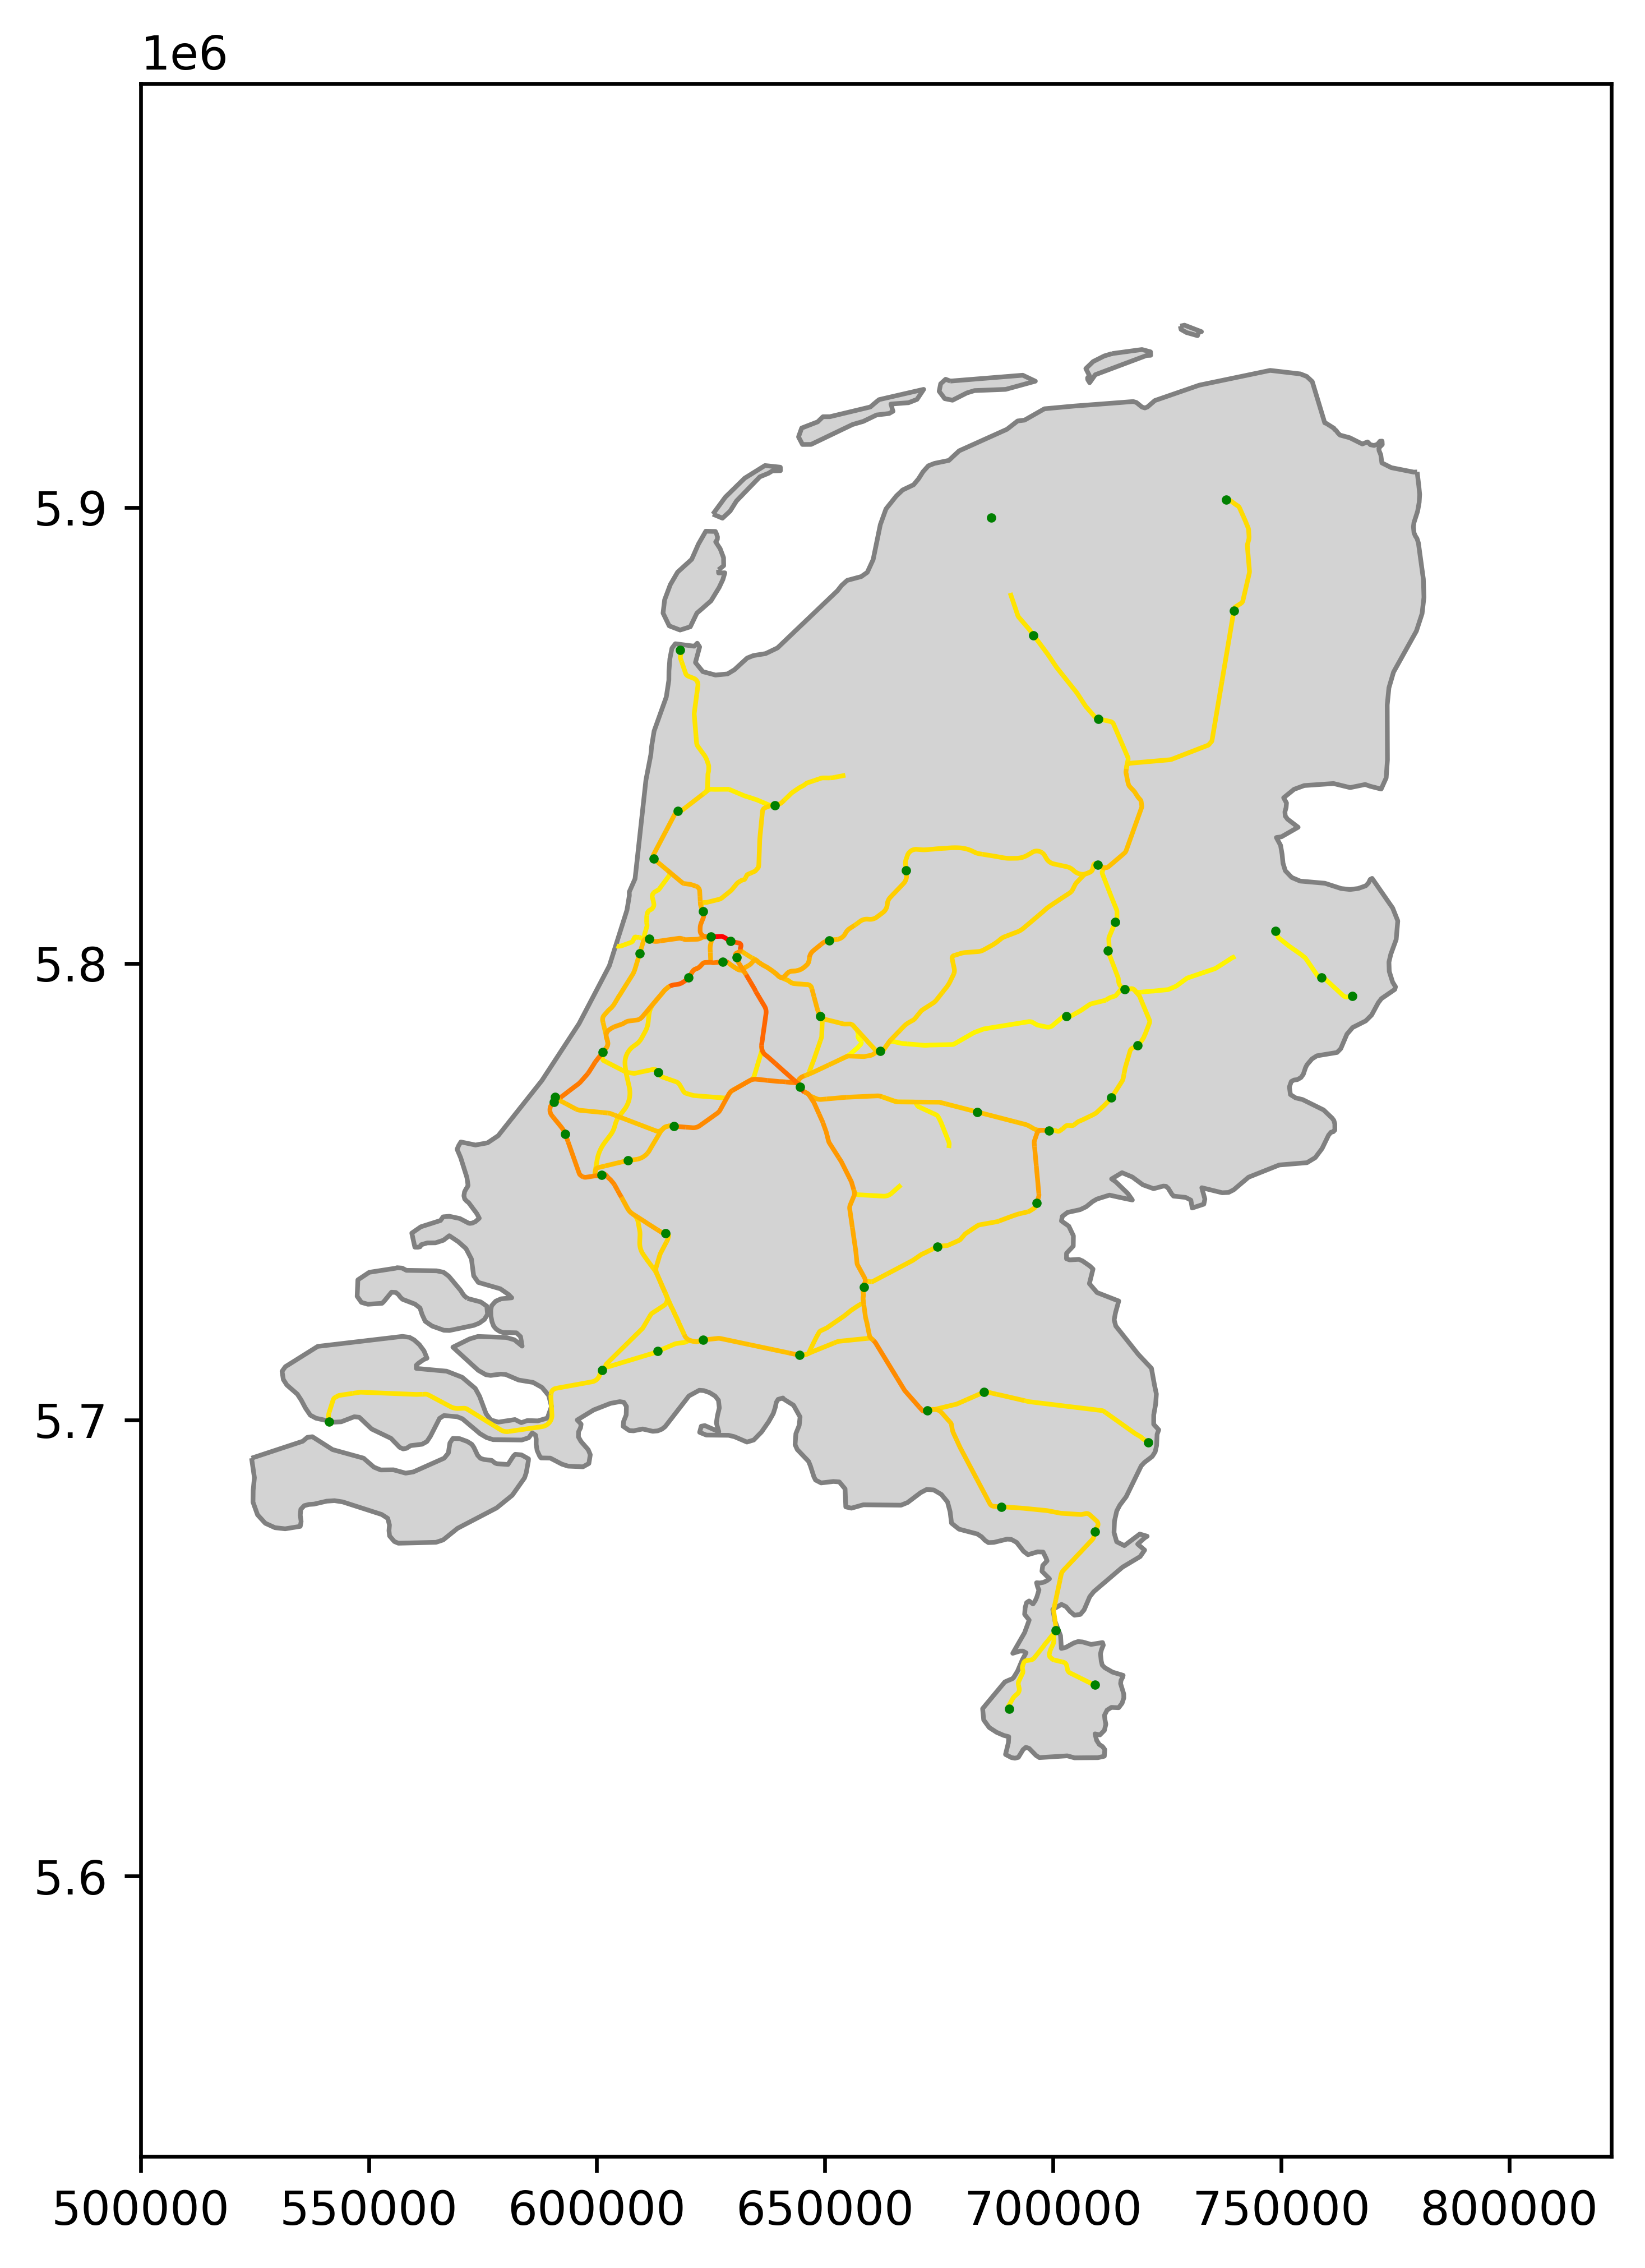

In [99]:
# Load the shapefile of the Netherlands
netherlands_shapefile_path = "ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp"
world = gpd.read_file(netherlands_shapefile_path)
netherlands = world[world['NAME'] == "Netherlands"]

# Set the CRS for the Netherlands shapefile to WGS84 (assuming it uses lat/lon)
netherlands = netherlands.set_crs(epsg=4326)

# Reproject the Netherlands shapefile to UTM (Zone 31N for the Netherlands)
netherlands = netherlands.to_crs(epsg=32631)

# Set the CRS for the dataframe `df` (assuming df contains lat/lon coordinates)
if df.crs is None:
    df = df.set_crs(epsg=4326)  # Set to WGS84 if no CRS is defined

# Reproject `df` to the same UTM projection (EPSG:32631)
df = df.to_crs(epsg=32631)

# Define original limits in WGS84 (lat/lon)
lon_min, lon_max = 3, 7.5
lat_min, lat_max = 50, 54

# Create a GeoDataFrame to represent the bounding box
bbox = gpd.GeoDataFrame(
    {'geometry': [box(lon_min, lat_min, lon_max, lat_max)]}, 
    crs="EPSG:4326"
)

# Reproject the bounding box to UTM (to match the Netherlands and df projection)
bbox = bbox.to_crs(epsg=32631)

# Extract the limits from the reprojected bounding box
minx, miny, maxx, maxy = bbox.total_bounds

# Create figure
fig, ax = plt.subplots(figsize=[12, 8], dpi=600)

# Set the new limits using the reprojected UTM coordinates
ax.set_xlim([minx, maxx])
ax.set_ylim([miny, maxy])

# Plot the reprojected Netherlands
netherlands.plot(ax=ax, color='lightgray', edgecolor='gray', zorder=1)

# Plot your data points with associated colors
for i in range(len(df)):
    df.iloc[[i]].plot(ax=ax, color=ast.literal_eval(df.loc[i, 'color']), linewidth=1, zorder=2)

# Importeren steden
steden = pd.read_csv('Randstad-0.csv')

# Convert the 'steden' DataFrame to a GeoDataFrame
steden['geometry'] = steden.apply(lambda row: Point(row['Lng-coord'], row['Lat-coord']), axis=1)
steden_gdf = gpd.GeoDataFrame(steden, geometry='geometry')

# Set the CRS for the cities to WGS84 (assuming the coordinates are in lat/lon)
steden_gdf = steden_gdf.set_crs(epsg=4326)

# Reproject the cities to the same CRS as the map (UTM Zone 31N)
steden_gdf = steden_gdf.to_crs(epsg=32631)
steden_gdf2 = steden_gdf[(steden_gdf['Type'] == 'knooppuntIntercitystation') | (steden_gdf['Type'] == 'megastation') | (steden_gdf['Type'] == 'intercitystation')].reset_index(drop=True)
steden_gdf2.plot(ax=ax, color='green', marker='o', markersize=1, zorder=3)

plt.show()

In [100]:
display(df)
df.to_csv('PlotDataWednesday.csv')

,index,From,To,Seats,geometry,color
0,272,GD,RTD,300.0,LINESTRING EMPTY,"[1.0, 1.0, 0.0]"
1,258,BRN,SD,1100.0,"LINESTRING (655842.751 5786662.626, 655923.979...","[1.0, 0.996078431372549, 0.0]"
2,260,ST,STZ,1100.0,"LINESTRING (657965.094 5782833.783, 657973.926...","[1.0, 0.996078431372549, 0.0]"
3,259,SD,ST,1100.0,"LINESTRING (657238.993 5783953.915, 657245.731...","[1.0, 0.996078431372549, 0.0]"
4,261,STZ,DLD,1100.0,"LINESTRING (657508.022 5781925.372, 657297.037...","[1.0, 0.996078431372549, 0.0]"
...,...,...,...,...,...,...
273,90,ASHD,ASB,265667.0,"LINESTRING (633634.17 5796040.942, 632996.071 ...","[1.0, 0.4, 0.0]"
274,51,SHL,HFD,274317.0,"LINESTRING (620123.834 5796913.324, 619998.945...","[1.0, 0.3803921568627451, 0.0]"
275,94,ASDM,ASD,284756.0,"LINESTRING (631481.677 5803089.149, 631481.647...","[1.0, 0.3568627450980392, 0.0]"
276,84,UTVR,UT,309904.0,"LINESTRING (645394.058 5771945.629, 645341.792...","[1.0, 0.30196078431372547, 0.0]"
